In [25]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'exchange_rate.csv'
data = pd.read_csv(file_path)

data['date'] = pd.to_datetime(data['date'], format='%d-%m-%Y %H:%M')

data.set_index('date', inplace=True)

print(data.head())


            Ex_rate
date               
1990-01-01   0.7855
1990-01-02   0.7818
1990-01-03   0.7867
1990-01-04   0.7860
1990-01-05   0.7849


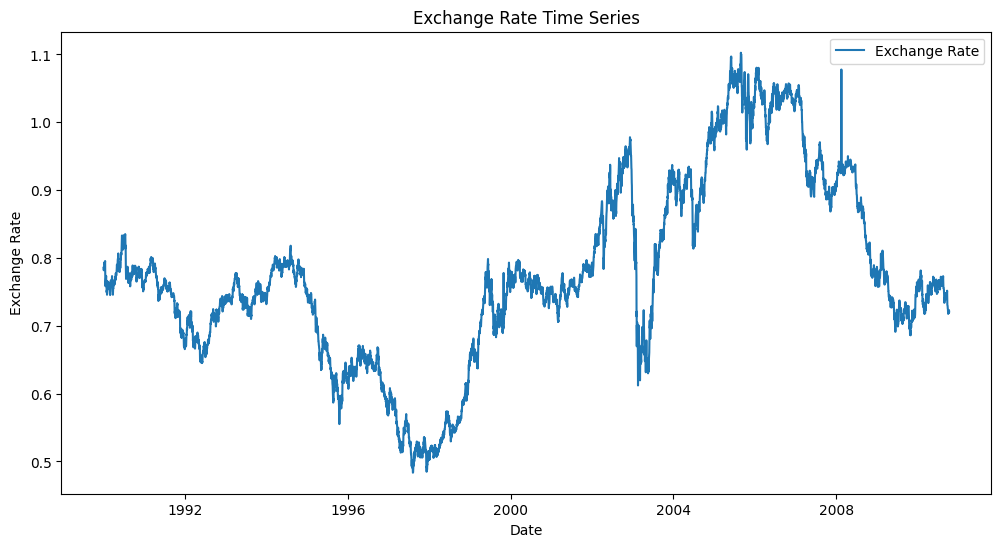

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(data['Ex_rate'], label='Exchange Rate')
plt.title('Exchange Rate Time Series')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()


In [27]:
print(data.isnull().sum())

data.fillna(method='ffill', inplace=True)

print(data.isnull().sum())


Ex_rate    0
dtype: int64
Ex_rate    0
dtype: int64


<ipython-input-27-b491208f0f2a>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


ADF Statistic: -1.6649941807382342
p-value: 0.4492327353597477


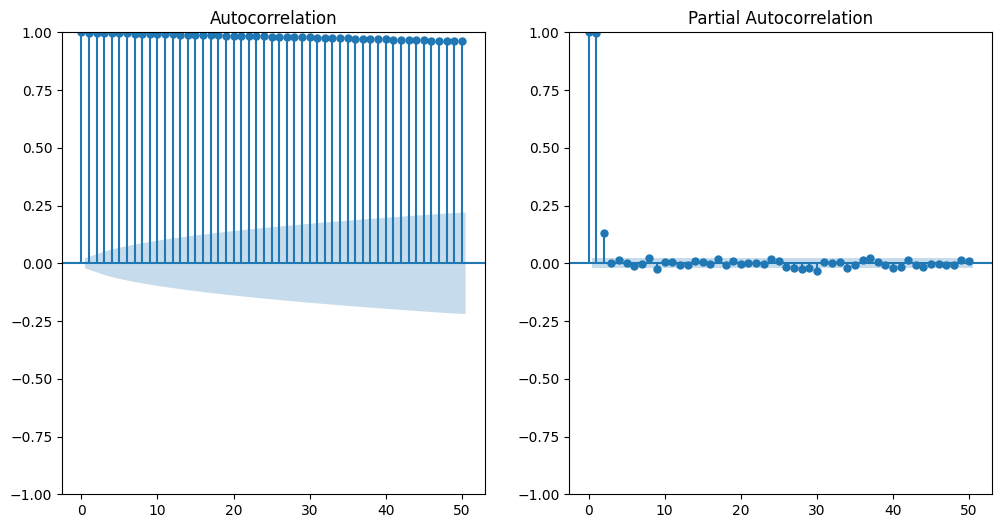

In [28]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Ex_rate'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(data['Ex_rate'].dropna(), lags=50, ax=plt.gca())
plt.subplot(122)
plot_pacf(data['Ex_rate'].dropna(), lags=50, ax=plt.gca())
plt.show()


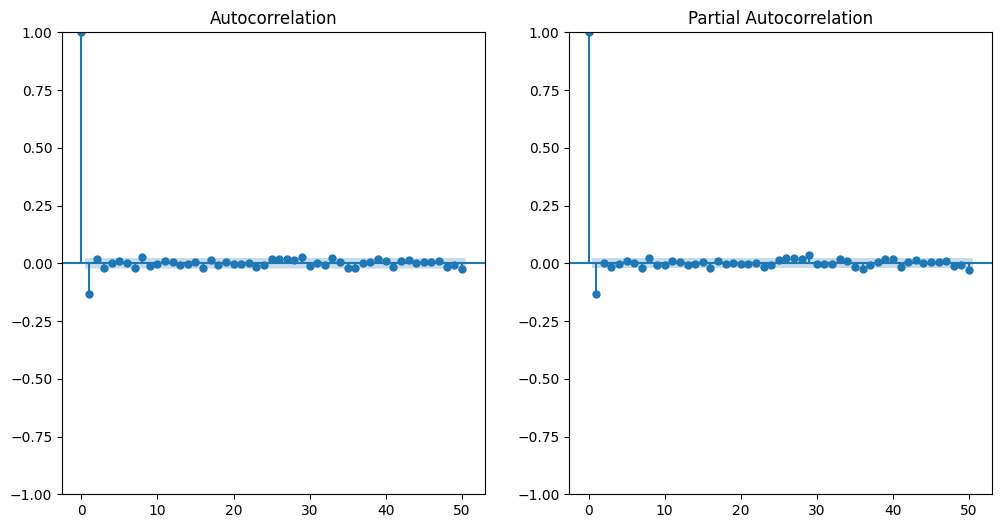

In [29]:
data['Ex_rate_diff'] = data['Ex_rate'] - data['Ex_rate'].shift(1)
data = data.dropna()

plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(data['Ex_rate_diff'], lags=50, ax=plt.gca())
plt.subplot(122)
plot_pacf(data['Ex_rate_diff'], lags=50, ax=plt.gca())
plt.show()


In [30]:
from statsmodels.tsa.arima.model import ARIMA

p, d, q = 1, 1, 1
model = ARIMA(data['Ex_rate'], order=(p, d, q))
model_fit = model.fit()

print(model_fit.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7587
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28050.093
Date:                Mon, 16 Dec 2024   AIC                         -56094.186
Time:                        06:03:48   BIC                         -56073.384
Sample:                    01-02-1990   HQIC                        -56087.047
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1270      0.045     -2.801      0.005      -0.216      -0.038
ma.L1         -0.0044      0.045     -0.097      0.923      -0.094       0.085
sigma2      3.596e-05   9.95e-08    361.568      0.0

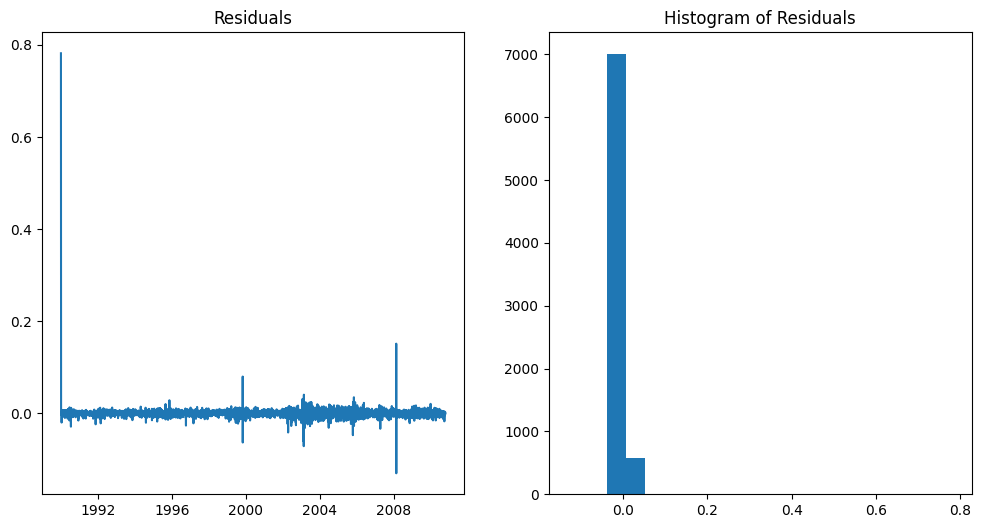

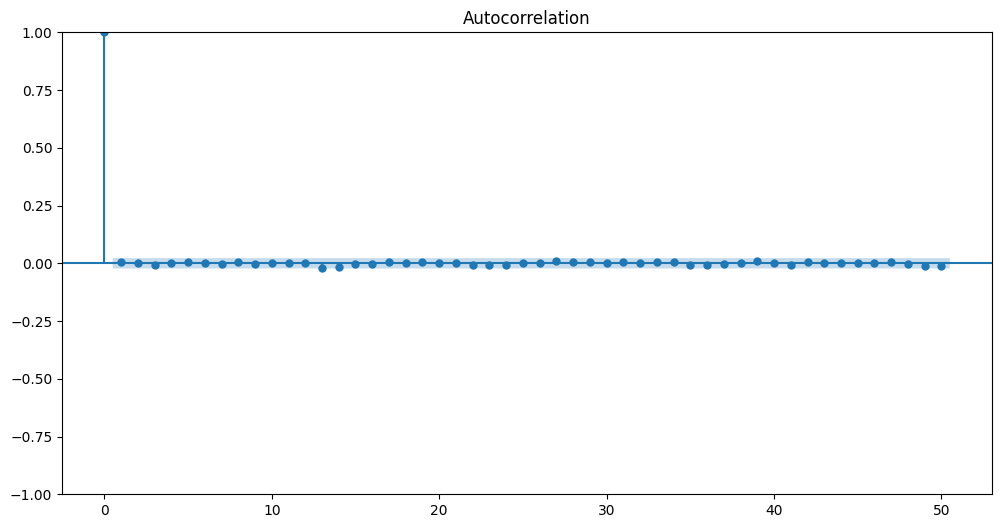

    lb_stat  lb_pvalue
10  0.94378   0.999868


In [31]:
residuals = model_fit.resid

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(residuals)
plt.title('Residuals')
plt.subplot(122)
plt.hist(residuals, bins=20)
plt.title('Histogram of Residuals')
plt.show()

plt.figure(figsize=(12, 6))
plot_acf(residuals, lags=50, ax=plt.gca())
plt.show()

from statsmodels.stats.diagnostic import acorr_ljungbox
ljung_box_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box_test)


In [32]:
import numpy as np
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import GridSearchCV

# Assume 'data' is your time series DataFrame and 'Ex_rate' is your target column
# For simplicity, we will use a train-test split approach to evaluate models

# Split into training and testing datasets
train_size = int(len(data) * 0.8)
train, test = data['Ex_rate'][:train_size], data['Ex_rate'][train_size:]

# Set up the parameter grid
param_grid = {
    'trend': ['add', 'mul', None],
    'seasonal': ['add', 'mul', None],
    'seasonal_periods': [12, 24, 52],
}

def optimize_exponential_smoothing(train_data, test_data, param_grid):
    best_aic = np.inf
    best_model = None
    best_params = None
    for trend in param_grid['trend']:
        for seasonal in param_grid['seasonal']:
            for seasonal_periods in param_grid['seasonal_periods']:
                try:
                    model = ExponentialSmoothing(train_data, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
                    model_fit = model.fit()
                    aic = model_fit.aic
                    if aic < best_aic:
                        best_aic = aic
                        best_model = model_fit
                        best_params = {'trend': trend, 'seasonal': seasonal, 'seasonal_periods': seasonal_periods}
                except Exception as e:
                    continue
    return best_model, best_params


best_model, best_params = optimize_exponential_smoothing(train, test, param_grid)

print(f"Best Parameters: {best_params}")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

Best Parameters: {'trend': None, 'seasonal': None, 'seasonal_periods': 12}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


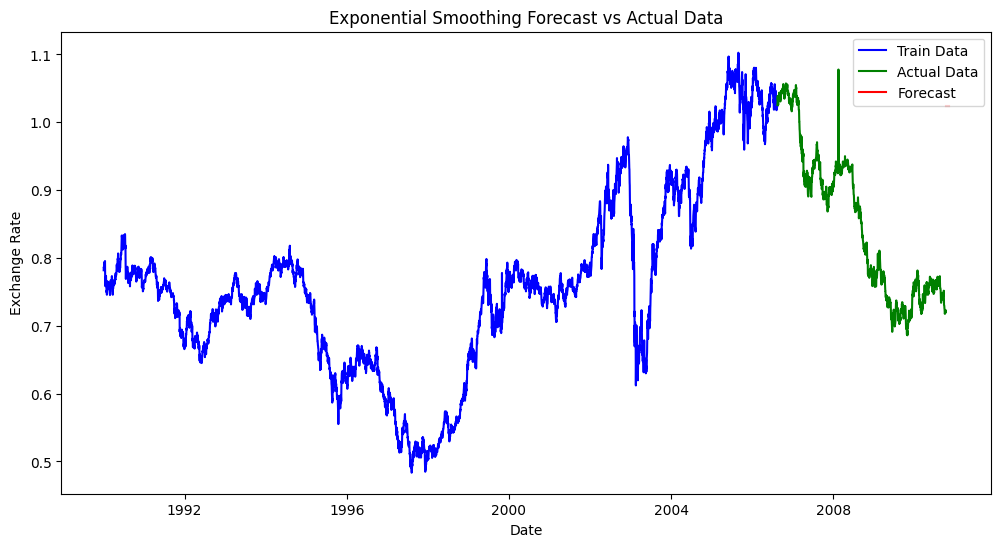

In [33]:
final_model = ExponentialSmoothing(train, trend=best_params['trend'], seasonal=best_params['seasonal'], seasonal_periods=best_params['seasonal_periods'])
model_fit = final_model.fit()

forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)

forecast_index = pd.date_range(start=test.index[-1], periods=forecast_steps+1, freq='D')[1:]

plt.figure(figsize=(12, 6))
plt.plot(train, label='Train Data', color='blue')
plt.plot(test, label='Actual Data', color='green')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.title('Exponential Smoothing Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()
